# More finalized plotting function

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import energies
import re



class mydict(dict):
    def __add__(self,other):
        out=mydict()
        for a in self:
            out[a]=self[a]
            if a in other:
                out[a]+=other[a]
        return out

def getpaths(fn, include=[],alldir=False):
    """Looks in the directory folder and returns all paths in a dictionary which groups by system size
    Inputs:
        fn - The directory name you want to get all the folder paths from
        include - a list of keystrings which must be included in any path you search
        alldir - if set to true, subdirectories of a valid path are included
    Outputs:
        A dictionary of L:[paths] pairs.
    """
    allpaths=mydict()
    for paths,folders,files in os.walk(fn):
        #print(paths)
        
        Lcomp = re.findall("\\\\[0-9]+-", paths)
        #print(Lcomp,paths)
        if len([a for a in include if a in paths])!=len(include):continue
        if len(paths.split("\\")[-1].split("-"))==1 and not alldir:continue
        if len(Lcomp)==1:
            Lcomp=int(Lcomp[0][1:-1]) 
            if not Lcomp in allpaths:
                allpaths[Lcomp]=[paths]
            else:
                allpaths[Lcomp]+=[paths]
    return allpaths
allpaths=getpaths("out\\TFIM")      
print(allpaths.keys())


def errplt(out,*args,**kwargs):
    """Plots with nice error bars"""
    fmt=None
    
    args = [a for a in args]
    for i in range(len(args)):
        if type(args[i])==type(str()):fmt=args[i];del args[i]
    if len(args)<2:in_=np.arange(out.shape[0])
    if len(args)==1:errs=args[0]
    if len(args)==2:in_,out,errs=out,args[0],args[1]
    if len(args)>0:        
        if fmt!= None:
            plt.plot(in_,out,fmt,**kwargs)
            if not "color" in kwargs:
                c=fmt[0]
            else:
                c=kwargs["color"]
            plt.fill_between(in_,out-errs,out+errs,color=c,alpha=0.4,lw=0.0)
        else:
            plt.plot(in_,out,**kwargs)
            plt.fill_between(in_,out-errs,out+errs,alpha=0.4)
            

def graphs(allpaths,useTimes=False, metric="Sample",label_idx=1,err=False,smoothing=100,show=True,verbose=False):
    """
    Inputs:
        allpaths - a dictionary where keys are Lattice sizes and values are lists of paths
        
        useTimes (bool) - False if you want to use training steps and True if you want to use computation time
        
        metric (string) - What evaluation metric to use, this should usually be set to sample
        
        label_idx (int or int[]) - Folder parameters are separated by - signs and label_idx takes the folder name
            and uses it to create graph labels. A decent usecase is to append a -<Name> to the end of you folder and
            set label_idx to -1 in order to just have your input <Name> as the label for the specific graph
        
        err (int) - when 1 results are plotted with errorbars, when 0 they are instead plotted in logscale
                        err=2 does something else
        
        smoothing (int) - used for smoothing out the graph. Set to 1 for the raw data, and n for data smoothed by
            averaging each points with the next n-1 points ahead of it (size n moving average)
    
        show (bool) - whether or not to call plt.show() if this isn't called you can mess about with the graph more 
            before you get your final plot
    """
    idx = {"SAMPLE":5,"CORRECTED":3,"TRAIN":1,"LOSS":4}[metric.upper()]
    for key in sorted(allpaths.keys()):
        if err ==2:
            fig = plt.figure(1,figsize=(6,6), dpi=240, facecolor='w', edgecolor='k')
        else:
            fig = plt.figure(1,figsize=(6,3.5), dpi=240, facecolor='w', edgecolor='k')
        plt.title("L = %d %s Energy"%(key,metric))
        firstplot = True

            
        if key in energies.Rydberg.E:
            exact_energy=energies.Rydberg.E[key]
            if err==2:
                pass#plt.ylim(-5e-3,1e-2)
            elif err==1:
                plt.ylim(-8e-4,8e-4)
            elif err==0:
                plt.yscale("log")
                plt.ylim(1e-5,5)
            elif err==3:
                pass
            else:
                exact_energy=0
                plt.yscale("log")
                plt.ylim(1e-5,5)
            
        else:
            exact_energy=energies.TFIM.ground(key,-1,1)
            
            if err:
                plt.ylim(-1e-3,5e-3)
            else:
                plt.yscale("log")
                plt.ylim(1e-6,2)

        print(key in energies.Rydberg.E,exact_energy)
        bestmin=1e-5
        ends=[]
        maxt=0
        for path in allpaths[key]:
            
            try:
                DEBUG = np.load(path+"\\DEBUG.npy")
                if verbose:print("-"*120+"\n",*["%.4f"%(a/key) for a in DEBUG[::500,5]],"\n"+"-"*120)
            except:
                #print("Multiple Runs. . .")
                DEBUG=None
                count=0
                for paths,folders,files in os.walk(path):
                    for f in folders:
                        dbg = np.load(path+"\\"+f+"\\DEBUG.npy")
                        if verbose:print("-"*120+"\n",*["%.4f"%(a/key) for a in dbg[::500,5]],"\n"+"-"*120)
                        if type(DEBUG)==type(None):
                            DEBUG=dbg
                            #DEBUG=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                        else:
                            DEBUG+=dbg
                            #DEBUG+=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                            
                        count+=1
                DEBUG=DEBUG/count
                #DEBUG=np.exp(DEBUG/count)+exact_energy*key
            times=DEBUG[:,-1]/60
            ends+=[times.max()]
            
            #averaging
            avgs=np.array([np.mean(DEBUG[max(i-smoothing+1,0):i+1,idx]) for i in range(DEBUG.shape[0])])/key
            errs = np.array([np.var(DEBUG[max(i-smoothing+1,0):i+1,idx])**0.5 for i in range(DEBUG.shape[0])])/key
            
            outs=avgs
            if exact_energy!=0:
                if not err:
                    outs=np.clip(avgs,exact_energy,10000)
                if outs.min()-exact_energy<bestmin:
                    bestmin=outs.min()-exact_energy
                    #plt.ylim(bestmin/2,5)
            
            #print(outs.mean())
            tmp=path.split("-")
            tmp=tmp[0].split("\\")+tmp[1:]
            if type(label_idx)==type([]):
                label = "".join([tmp[i]+"," for i in label_idx])[:-1]
            else:
                label = tmp[label_idx]
            
            print("L=%d %s: %f"%(key,label,avgs.min()),end="|")
            #plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,alpha=0.1,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
            
            if err==2:
                try:
                    with open(path+"\\RESULT-1024.txt","r") as tmpfile:
                        res=tmpfile.readline().strip().split()
                        
                except:
                    with open(path+"\\0\\RESULT-1024.txt","r") as tmpfile:
                        res=tmpfile.readline().strip().split()
                plt.errorbar([times[-1]],[float(res[0])],[float(res[-1])],marker='o',ms=3,label=label)
                maxt=max(maxt,times[-1])
            elif useTimes:
                x = plt.plot(times,outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
                plt.plot(times,exact_energy-avgs,'o',ms=1.5,c=x[0]._get_markerfacecolor(),alpha=0.1,markeredgewidth=0.2,markeredgecolor="black")

            else:
                if err>2:
                    errplt(outs-exact_energy,errs,"-",lw=0.5,label=label,color=np.random.random([3]))
                elif err>0:
                    errplt(outs-exact_energy,errs,"-",lw=0.5,label=label,color=np.random.random([3]))
                    plt.plot(outs*0,"k--",lw=0.2)
                else:
                    if key in energies.Rydberg.Err and firstplot:
                        delta=energies.Rydberg.Err[key]
                        plt.plot(outs*0+delta,"k--",lw=0.2,label="Error")

                    x = plt.plot(outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
                    plt.plot(exact_energy-avgs,'o',ms=1.5,c=x[0]._get_markerfacecolor(),alpha=0.1,markeredgewidth=0.2,markeredgecolor="black")
                    
                    
            firstplot=False
            
        
        print()
        if useTimes:
            
            if key in energies.Rydberg.Err and not err:
                delta=energies.Rydberg.Err[key]
                plt.plot([0,np.max(ends)],[delta,delta],"k--",lw=0.2,label="Error")
                
            plt.xlim(0,np.max(ends))
            plt.xlabel("Time (min)",fontsize=15)
        else:
            plt.xlabel("Step")
            
        if err==2:
            plt.plot([0,maxt],[exact_energy]*2,"k--",lw=0.2,label="Exact")
            plt.xlabel("Execution Time")
        plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
        plt.legend(loc="best",fontsize=6)
        if show:
            plt.show()

dict_keys([])


# Usage:

- getpaths works similar to a query:<br>
    Select X<br>
    From fn<br>
    Where every string in include is a substring of X<br><br>
    
- getpaths returns a dictionary of arrays where keys are system sizes.

- each different system size will result in a new graph

- For a given system every folder in the corresponding array will be plotted on the same graph

- You can add new folders at a given system size by just doing array addition

True -0.3724
------------------------------------------------------------------------------------------------------------------------
 2.8483 -0.2824 -0.2957 -0.3150 -0.3341 -0.3474 -0.3564 -0.3599 -0.3625 -0.3630 -0.3655 -0.3656 -0.3673 -0.3668 -0.3681 -0.3690 -0.3699 -0.3708 -0.3714 -0.3706 -0.3713 -0.3711 -0.3713 -0.3714 
------------------------------------------------------------------------------------------------------------------------
L=576 P=8x8B: -0.371664|


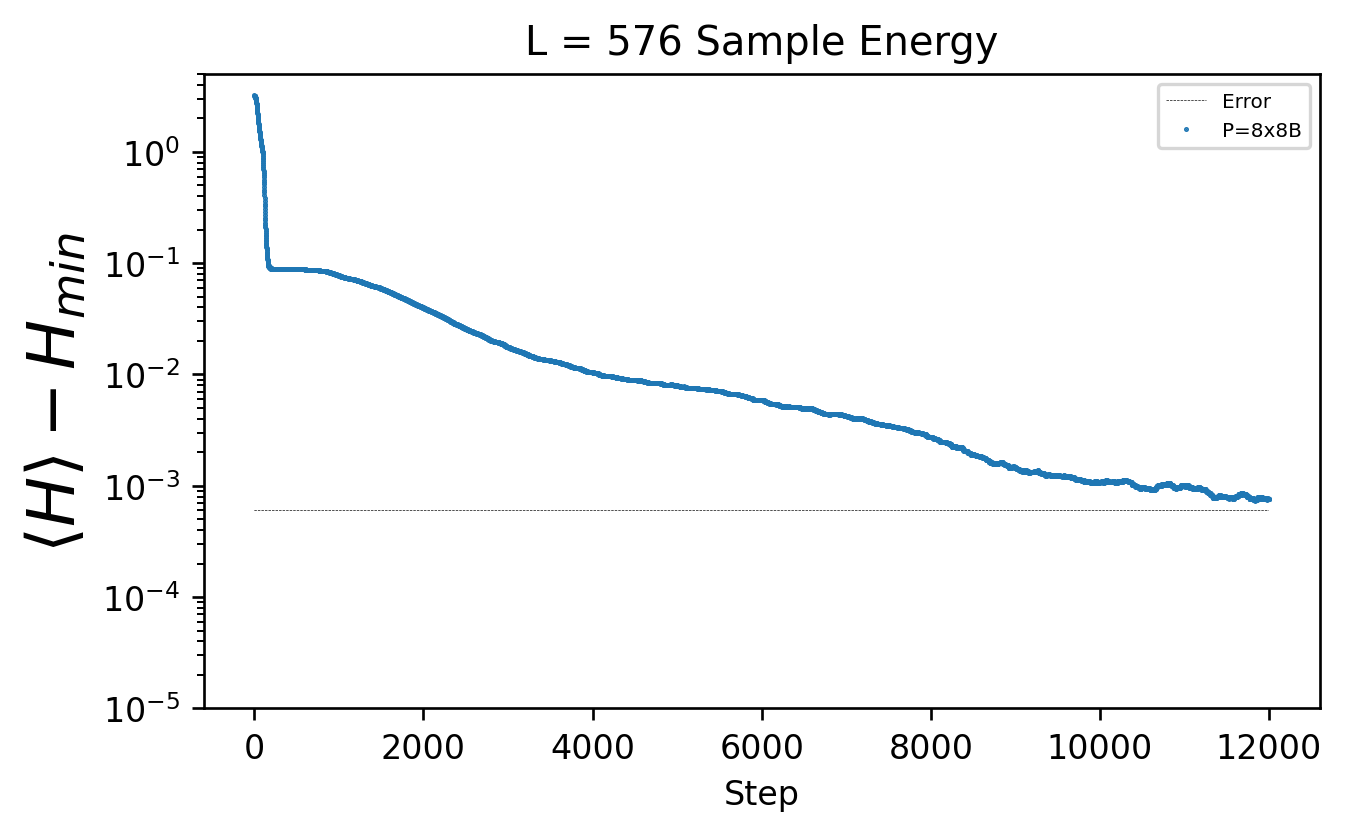

True -0.3645
------------------------------------------------------------------------------------------------------------------------
 -0.3310 -0.3635 
------------------------------------------------------------------------------------------------------------------------
L=2304 P=8x8_LPTF: -0.363676|


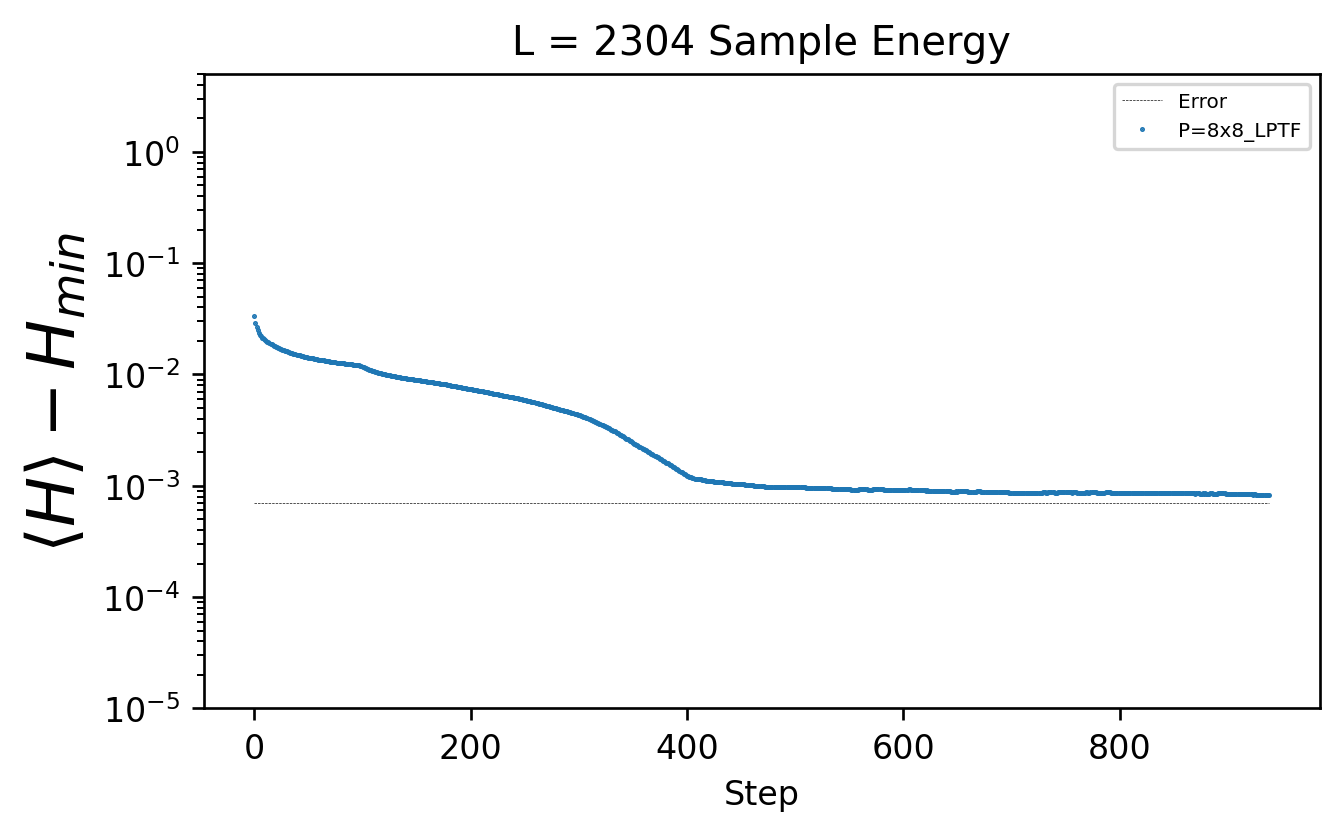

True 0
------------------------------------------------------------------------------------------------------------------------
 0.3303 0.0130 0.0085 0.0007 
------------------------------------------------------------------------------------------------------------------------
L=2304 TRANSFER: 0.000392|


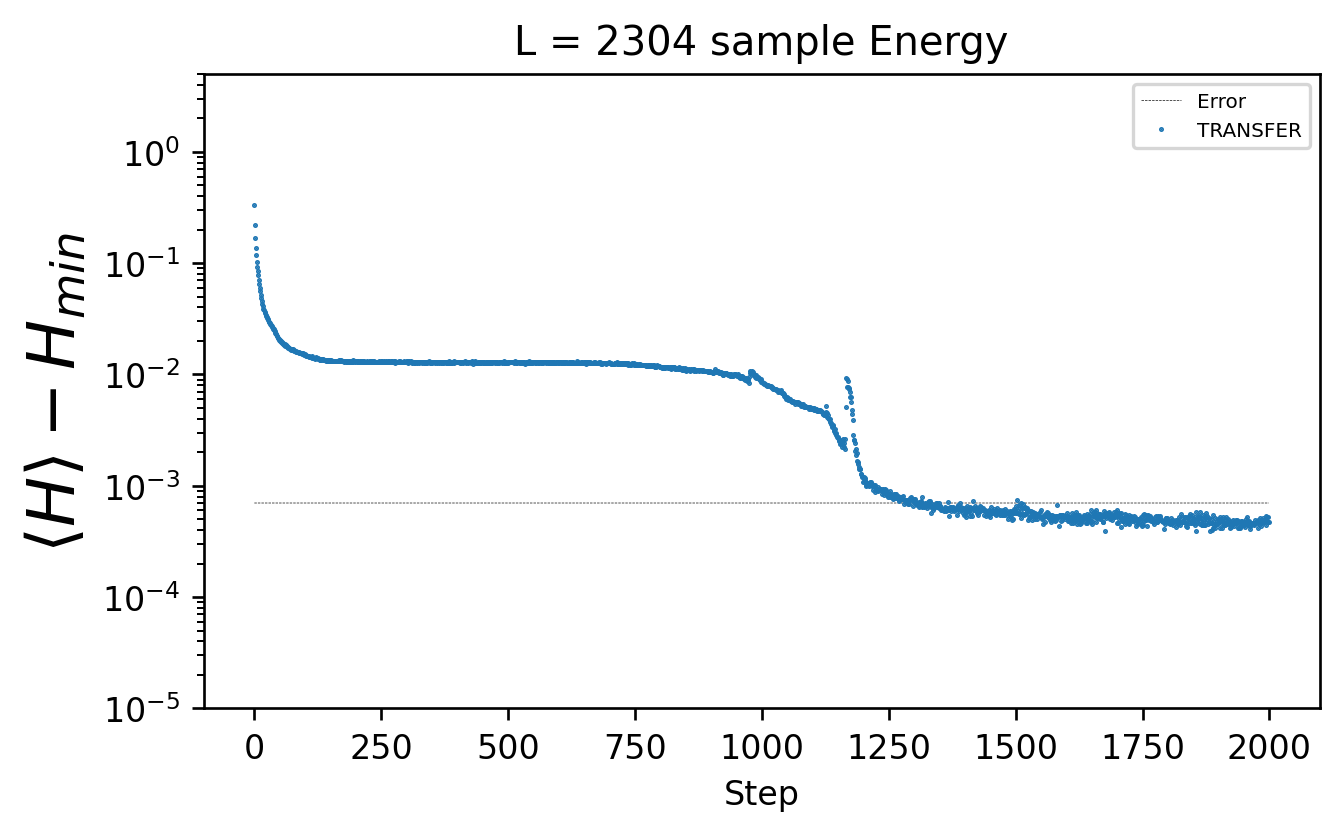

In [20]:
ptf = getpaths("LPTF\\Rydberg",["576","8x8B"])
graphs(ptf,label_idx=-1,useTimes=False,verbose=True,smoothing=100)

ptf = getpaths("FINE-TUNE\\Rydberg",["2304","8x8"])
graphs(ptf,label_idx=-1,useTimes=False,verbose=True,smoothing=100)

transfer = getpaths("TRANSFER\\Rydberg",["B=512","\\1"],alldir=True)
graphs(transfer,label_idx=0,useTimes=False,err=-1,verbose=True,metric="sample",smoothing=1)

True -0.3645
------------------------------------------------------------------------------------------------------------------------
 -0.3638 -0.3643 -0.3645 -0.3645 
------------------------------------------------------------------------------------------------------------------------
L=2304 P=4x4_LPTF: -0.364475|


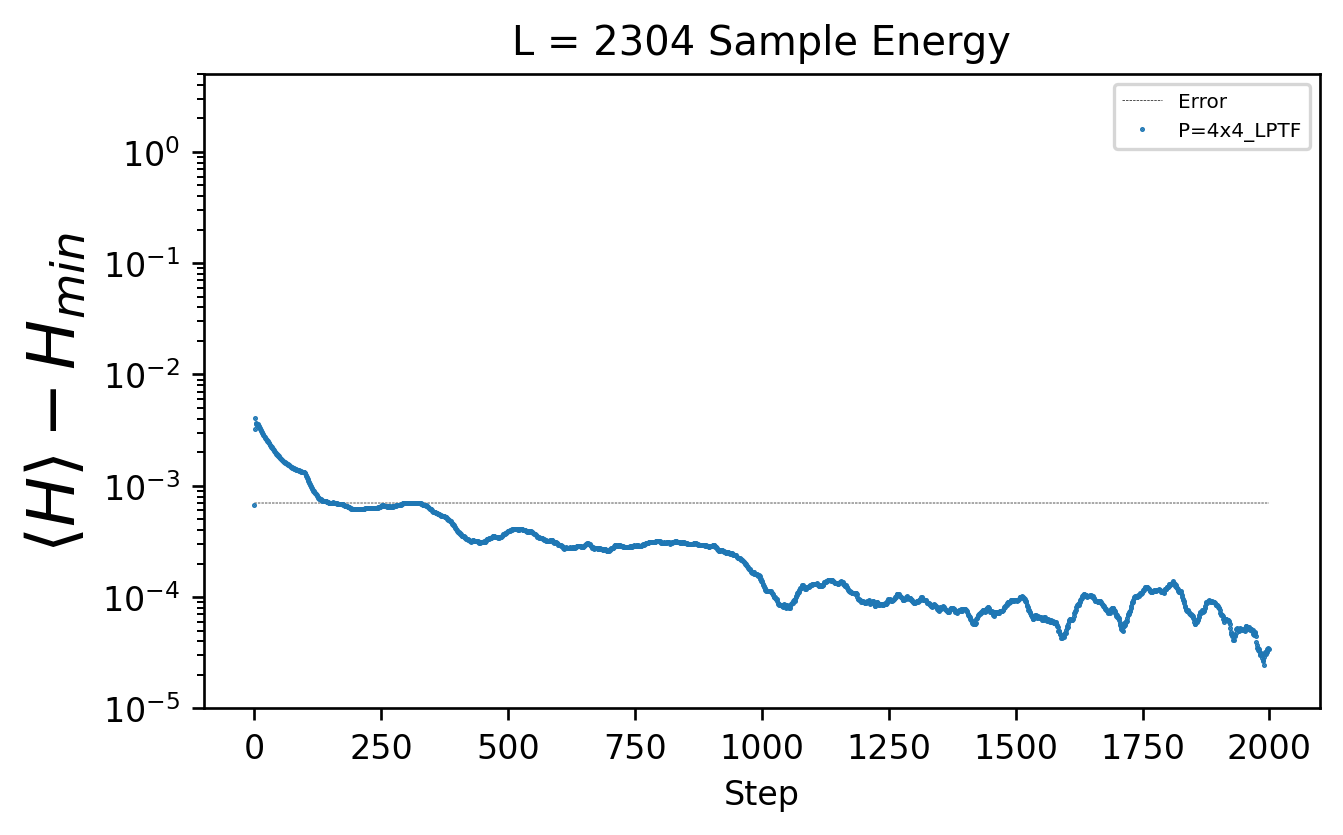

In [21]:
ptf = getpaths("FINE-TUNE\\Rydberg",["2304","4x4"])
graphs(ptf,label_idx=-1,useTimes=False,verbose=True,smoothing=100)

True -0.3645
L=2304 LEGACY: -0.364765|L=2304 FINE: -0.364571|


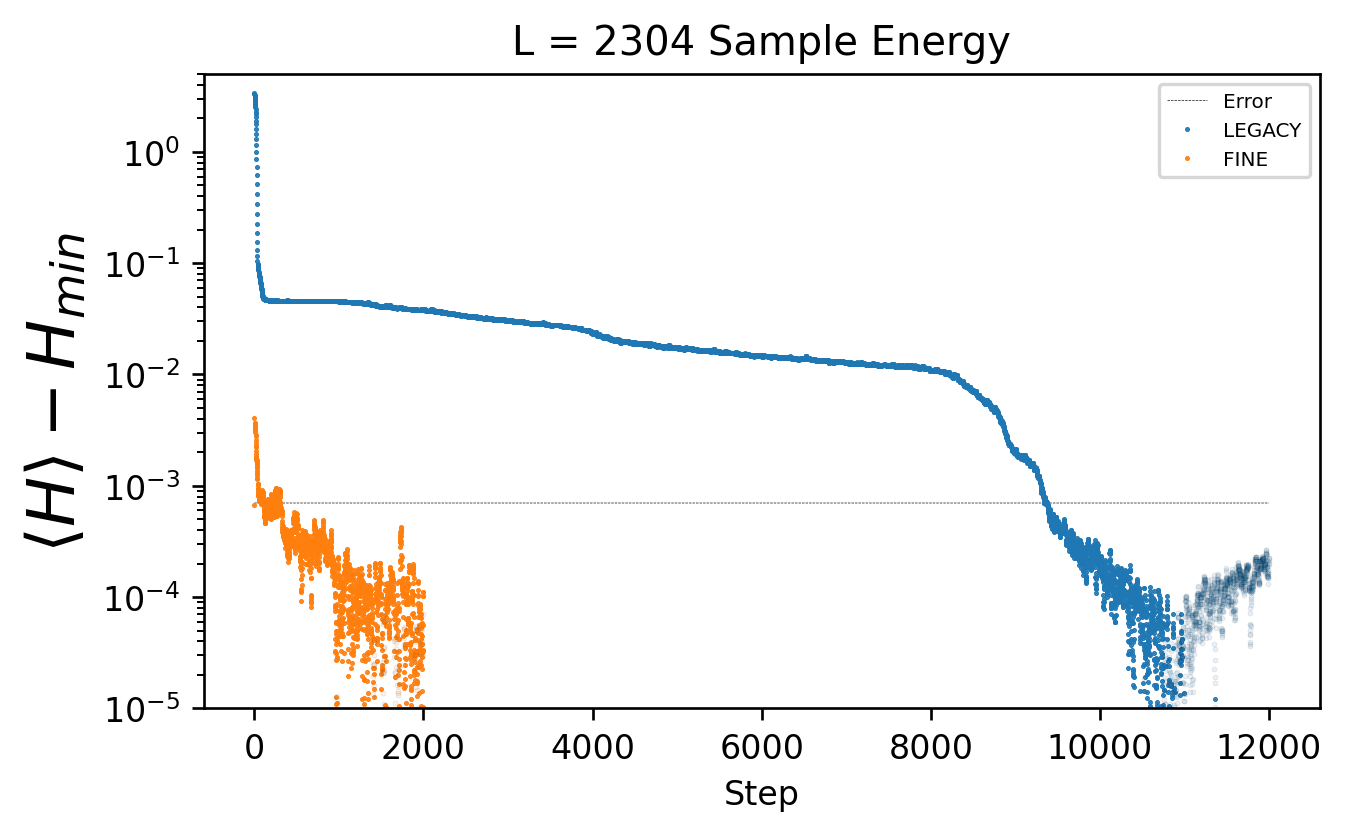

In [24]:
legptf = getpaths("LEGACY\\Rydberg",["2304-NoQ","B=256"])
ptf = getpaths("FINE-TUNE\\Rydberg",["2304","4x4"])
graphs(legptf+ptf,label_idx=0,useTimes=False,err=0,smoothing=10)




True -0.3645
------------------------------------------------------------------------------------------------------------------------
 -0.3641 
------------------------------------------------------------------------------------------------------------------------
L=2304 P=2x2_PTF: -0.364796|


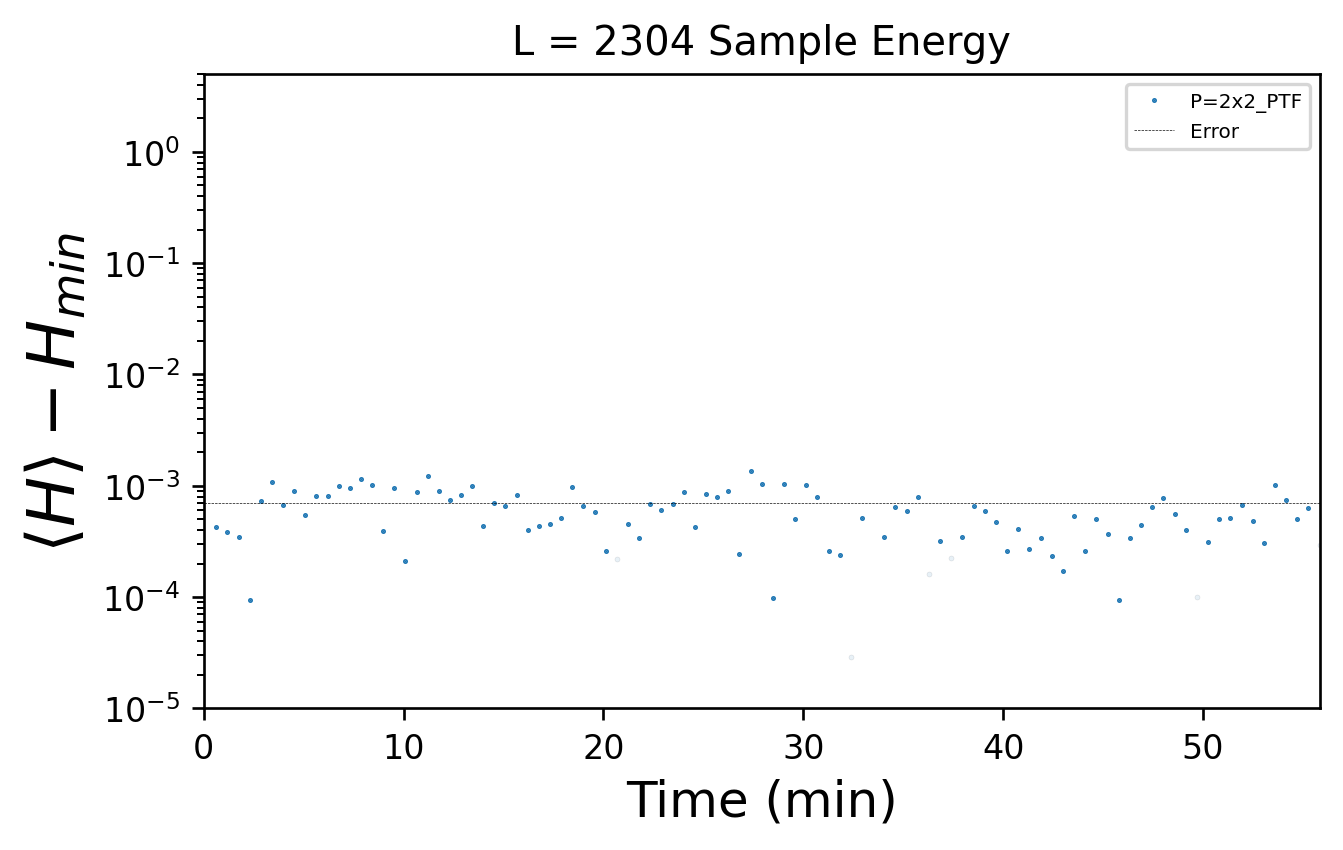

In [8]:
ptf = getpaths("FINE-TUNE\\Rydberg",["2304"])
graphs(ptf,label_idx=-1,useTimes=True,verbose=True,smoothing=1)

True -0.3724
L=576 P=2x2: -0.372766|L=576 P=3x3: -0.372656|L=576 P=3x3B: -0.372770|L=576 P=8x8: -0.372197|L=576 P=8x8B: -0.371664|


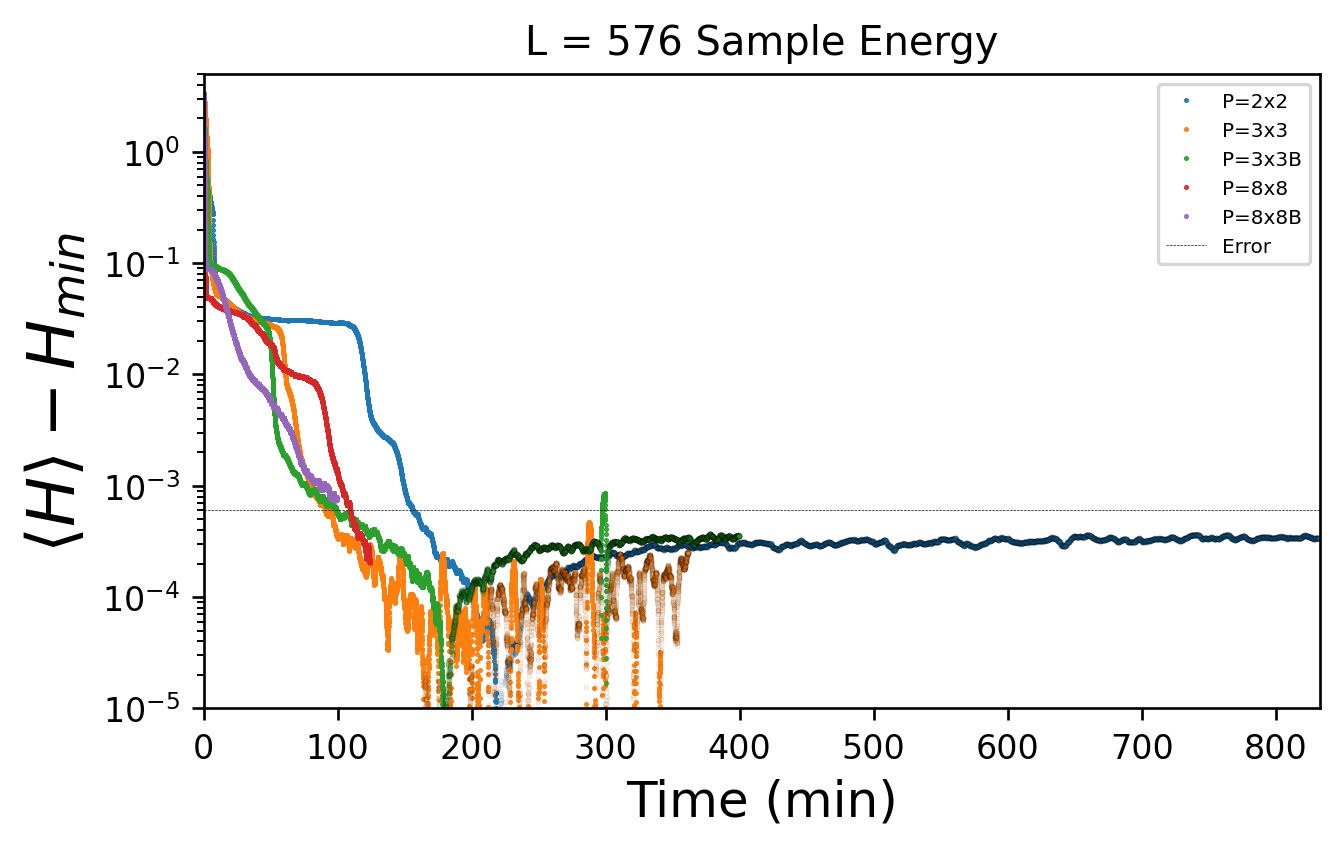

In [8]:
ptf = getpaths("PTF\\Rydberg",["576-B"])
ptf += getpaths("LPTF\\Rydberg",["576-B"])
graphs(ptf,label_idx=-1,useTimes=True)

True -0.4534
L=16 P=2: -0.453390|L=16 P=2x2: -0.453389|L=16 P=4: -0.453399|L=16 P=2x2: -0.453444|L=16 2D: -0.453335|


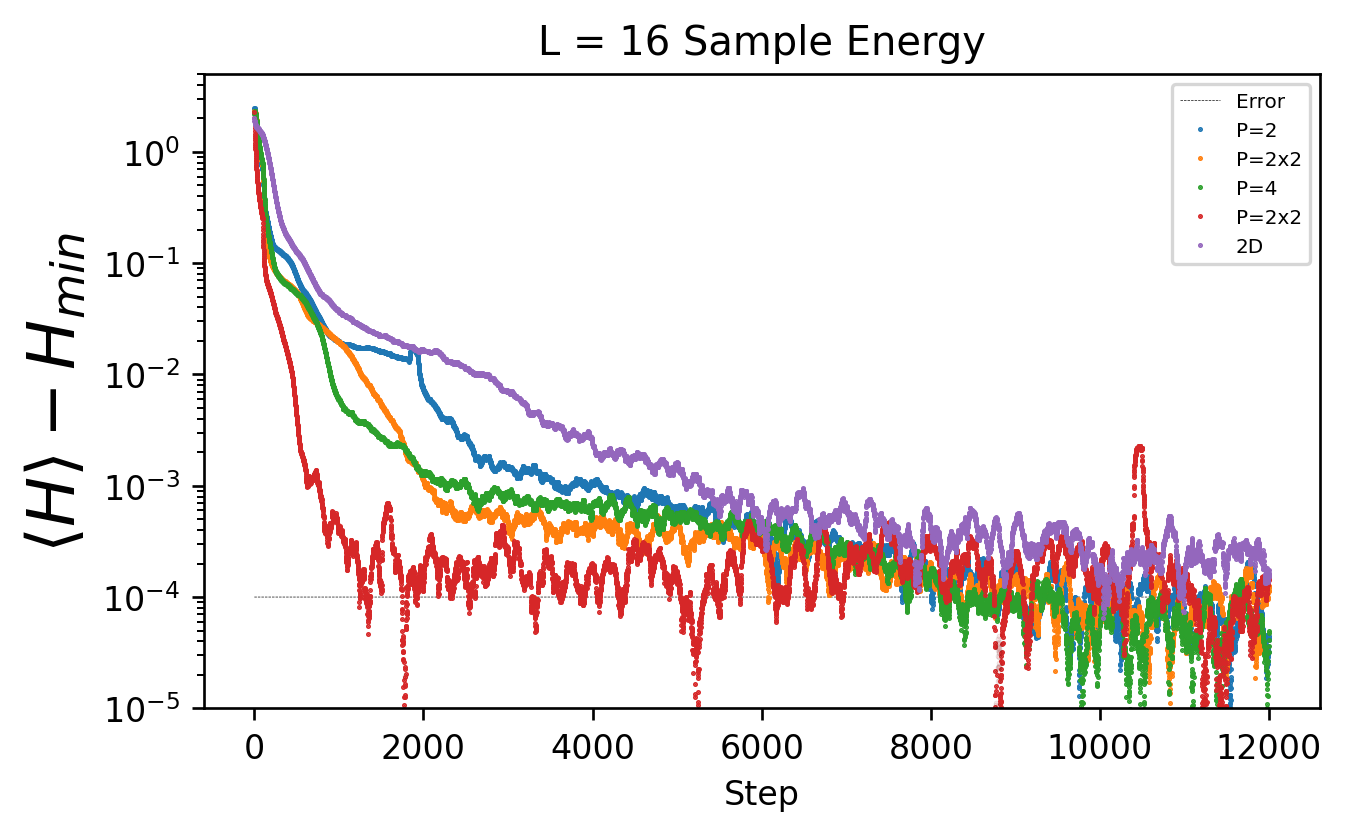

In [14]:
rnn = getpaths("RNN\\Rydberg")
ptf = getpaths("PTF\\Rydberg")
graphs(rnn+ptf,label_idx=-1,useTimes=False)

In [23]:
energies.Rydberg.E[256]=-0.380741
#energies.Rydberg.E[64]=-0.405574
energies.Rydberg.E[576]=-0.372778

True -0.38052
------------------------------------------------------------------------------------------------------------------------
 2.8576 -0.3400 -0.3448 -0.3479 -0.3484 -0.3593 -0.3759 -0.3794 -0.3802 -0.3805 -0.3800 -0.3800 -0.3801 -0.3804 -0.3805 -0.3805 -0.3808 -0.3804 -0.3805 -0.3803 -0.3806 -0.3806 -0.3806 -0.3808 
------------------------------------------------------------------------------------------------------------------------
L=256 LPTF,RNN\Rydberg\256: -0.380616|------------------------------------------------------------------------------------------------------------------------
 2.9184 -0.3460 -0.3484 -0.3790 -0.3799 -0.3805 -0.3807 -0.3807 -0.3805 -0.3807 -0.3808 -0.3807 -0.3808 -0.3806 -0.3806 -0.3810 -0.3807 -0.3807 -0.3807 -0.3808 -0.3806 -0.3807 -0.3807 -0.3807 
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------

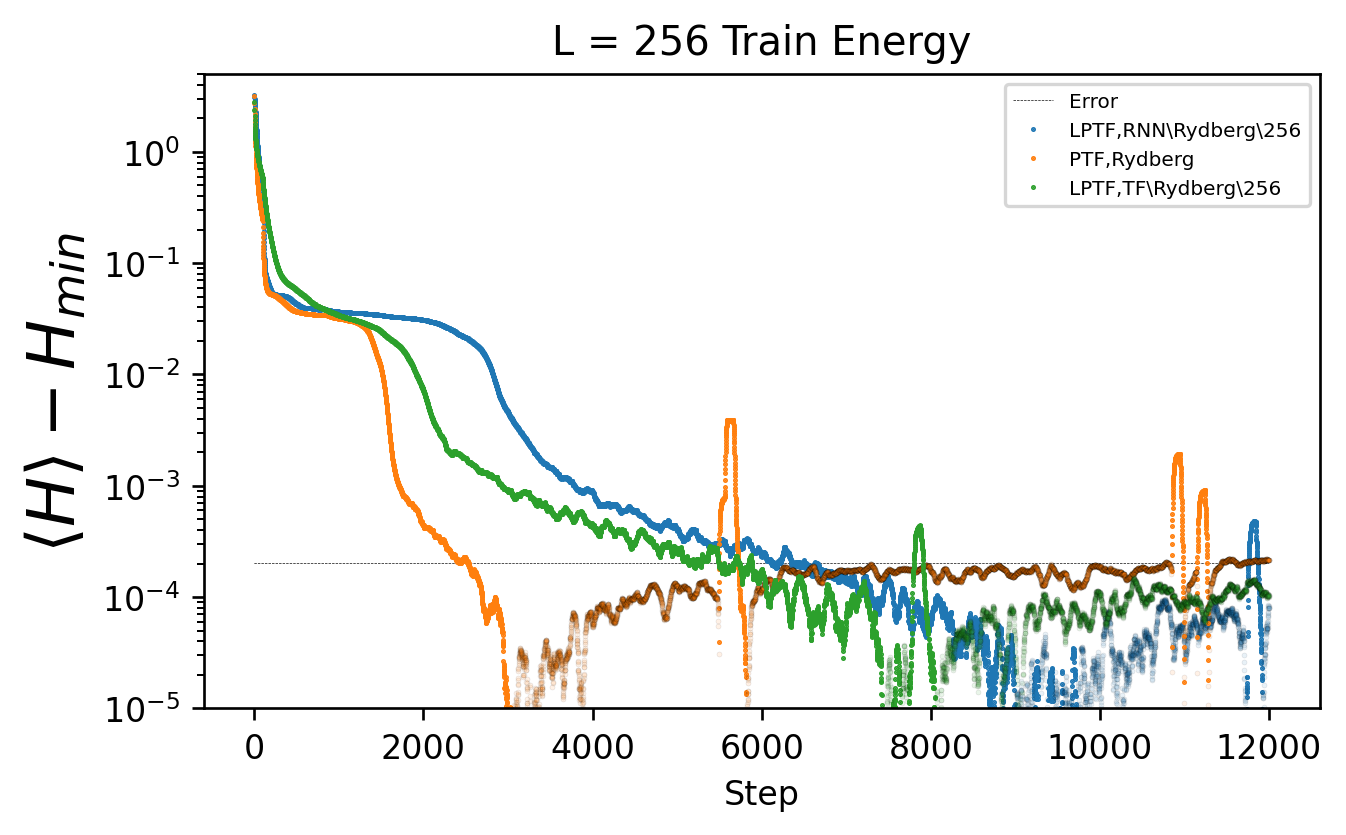

True -0.3724
------------------------------------------------------------------------------------------------------------------------
 2.9285 -0.3307 -0.3350 -0.3376 -0.3415 -0.3528 -0.3689 -0.3711 -0.3716 -0.3721 -0.3724 -0.3723 -0.3723 -0.3724 -0.3722 -0.3725 -0.3724 -0.3725 -0.3728 -0.3723 -0.3725 -0.3726 -0.3727 -0.3726 
------------------------------------------------------------------------------------------------------------------------
L=576 LPTF,RNN\Rydberg\576: -0.372670|------------------------------------------------------------------------------------------------------------------------
 2.8753 -0.3359 -0.3384 -0.3412 -0.3696 -0.3723 -0.3723 -0.3725 -0.3720 -0.3722 -0.3726 -0.3726 -0.3726 -0.3727 -0.3728 -0.3728 -0.3727 -0.3727 -0.3727 -0.3727 -0.3728 -0.3728 -0.3727 -0.3728 
------------------------------------------------------------------------------------------------------------------------
L=576 PTF,Rydberg: -0.372778|--------------------------------------------------

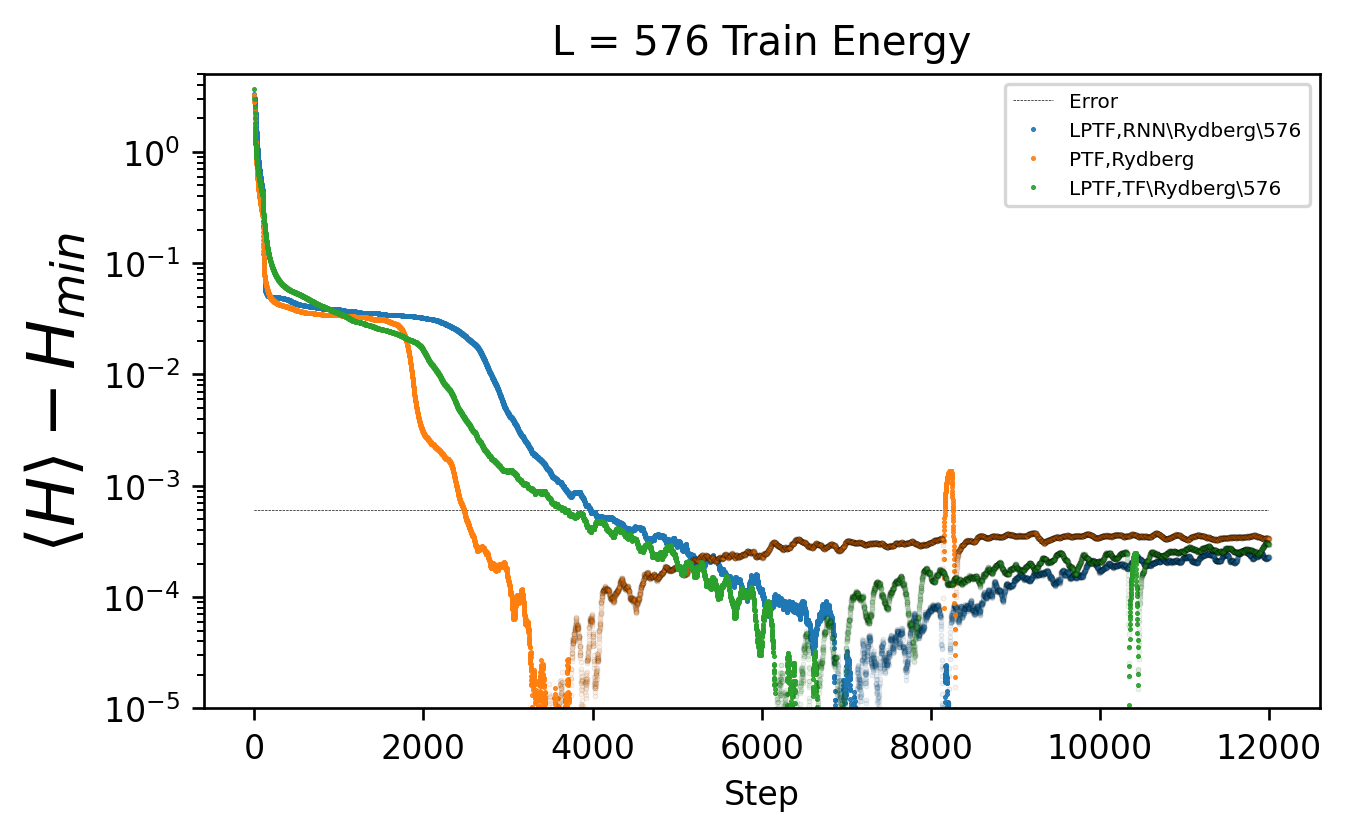

True -0.3687
------------------------------------------------------------------------------------------------------------------------
 2.9661 -0.3262 -0.3310 -0.3340 -0.3348 -0.3406 -0.3454 -0.3631 -0.3660 -0.3679 -0.3683 -0.3684 -0.3683 -0.3682 -0.3686 -0.3684 -0.3687 -0.3685 -0.3685 -0.3689 -0.3685 -0.3687 -0.3688 -0.3687 
------------------------------------------------------------------------------------------------------------------------
L=1024 LPTF,RNN\Rydberg\1024: -0.368811|------------------------------------------------------------------------------------------------------------------------
 2.6129 -0.3222 -0.3344 -0.3416 -0.3477 -0.3507 -0.3647 -0.3678 -0.3681 -0.3681 -0.3682 -0.3681 -0.3684 -0.3686 -0.3686 -0.3686 -0.3687 -0.3687 -0.3687 -0.3688 -0.3687 -0.3687 -0.3688 -0.3688 
------------------------------------------------------------------------------------------------------------------------
L=1024 LPTF,TF\Rydberg\1024: -0.368830|--------------------------------------

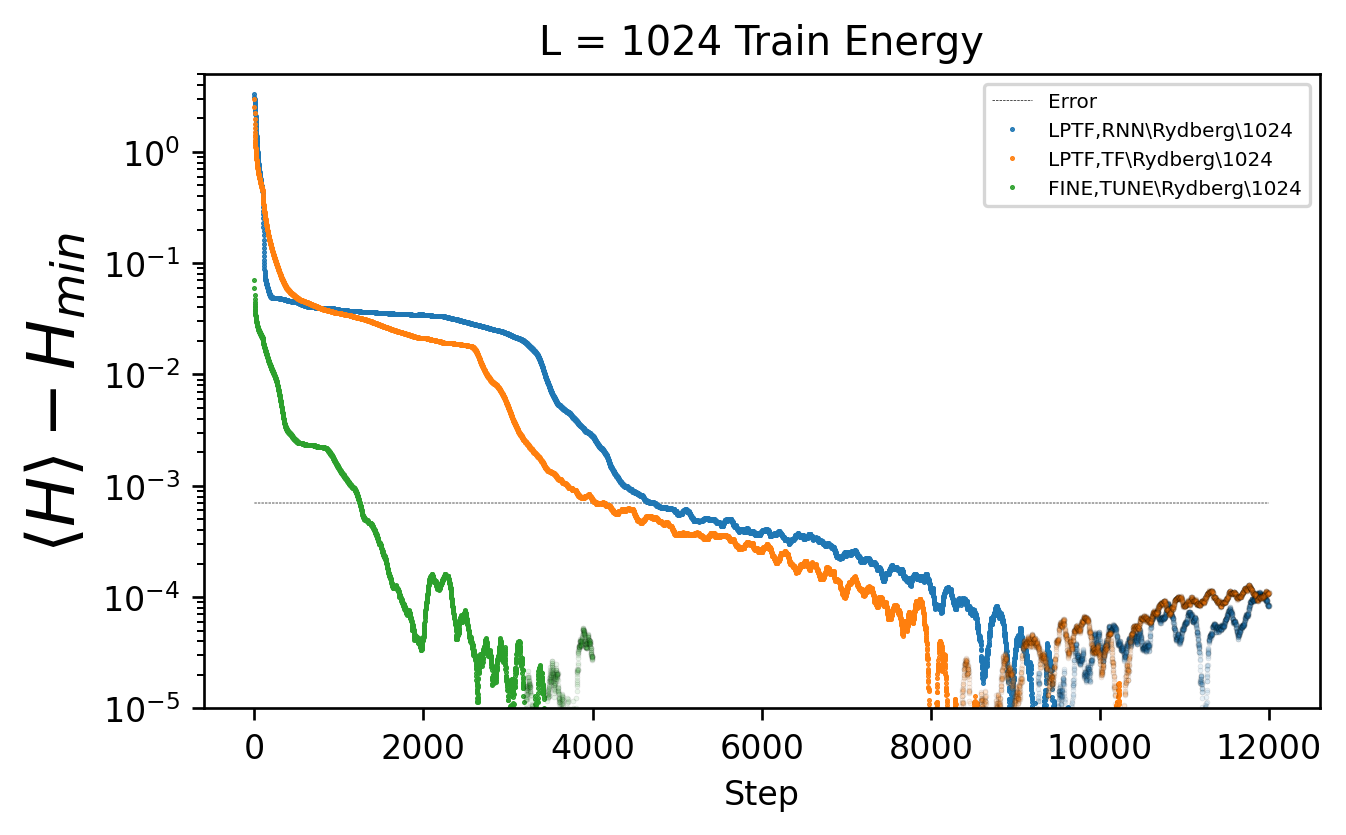

In [4]:
ptf=getpaths("PTF\\Rydberg",["NoQ"],alldir=False)
pptf=getpaths("LPTF-RNN\\Rydberg",["NoQ","2D"],alldir=False)
pptf2=getpaths("LPTF-TF\\Rydberg",["NoQ","2D"],alldir=False)
pptf3=getpaths("FINE-TUNE\\Rydberg",["NoQ","2D\\R"],alldir=True)
graphs(pptf+ptf+pptf2+pptf3,useTimes=False, metric="Train",label_idx=[0,1],err=0,smoothing=100,show=True,verbose=True)
#plt.xlim(0,2000)

In [4]:
pptf3

{1024: ['FINE-TUNE\\Rydberg\\1024-NoQ-B=256-K=256-Nh=128-P=4-2D\\1']}

In [9]:
dbg0=np.load("LPTF-RNN\\Rydberg\\256-NoQ-B=256-K=256-Nh=128-P=4-2D\\0\\DEBUG.npy")
dbg1=np.load("FINE-TUNE\\Rydberg\\1024-NoQ-B=256-K=256-Nh=128-P=4-2D\\0\\DEBUG.npy")
dbg2=np.load("FINE-TUNE\\Rydberg\\1024-NoQ-B=256-K=256-Nh=128-P=4-2D\\1\\DEBUG.npy")



In [10]:
dbg3 = np.concatenate([dbg1,dbg2])

dbg3[:,-1]+=dbg0[-1,-1]
dbg3[2000:,-1]+=dbg1[-1,-1]

np.save("FINE-TUNE\\Rydberg\\1024-NoQ-B=256-K=256-Nh=128-P=4-2D\\R\\DEBUG.npy",dbg3)


False -1.273566852856423
L=40 RNN,P=1: -1.273541|L=40 RNN,P=4: -1.273558|L=40 PTF,P=4: -1.273551|L=40 PTF,P=4: -1.273569|


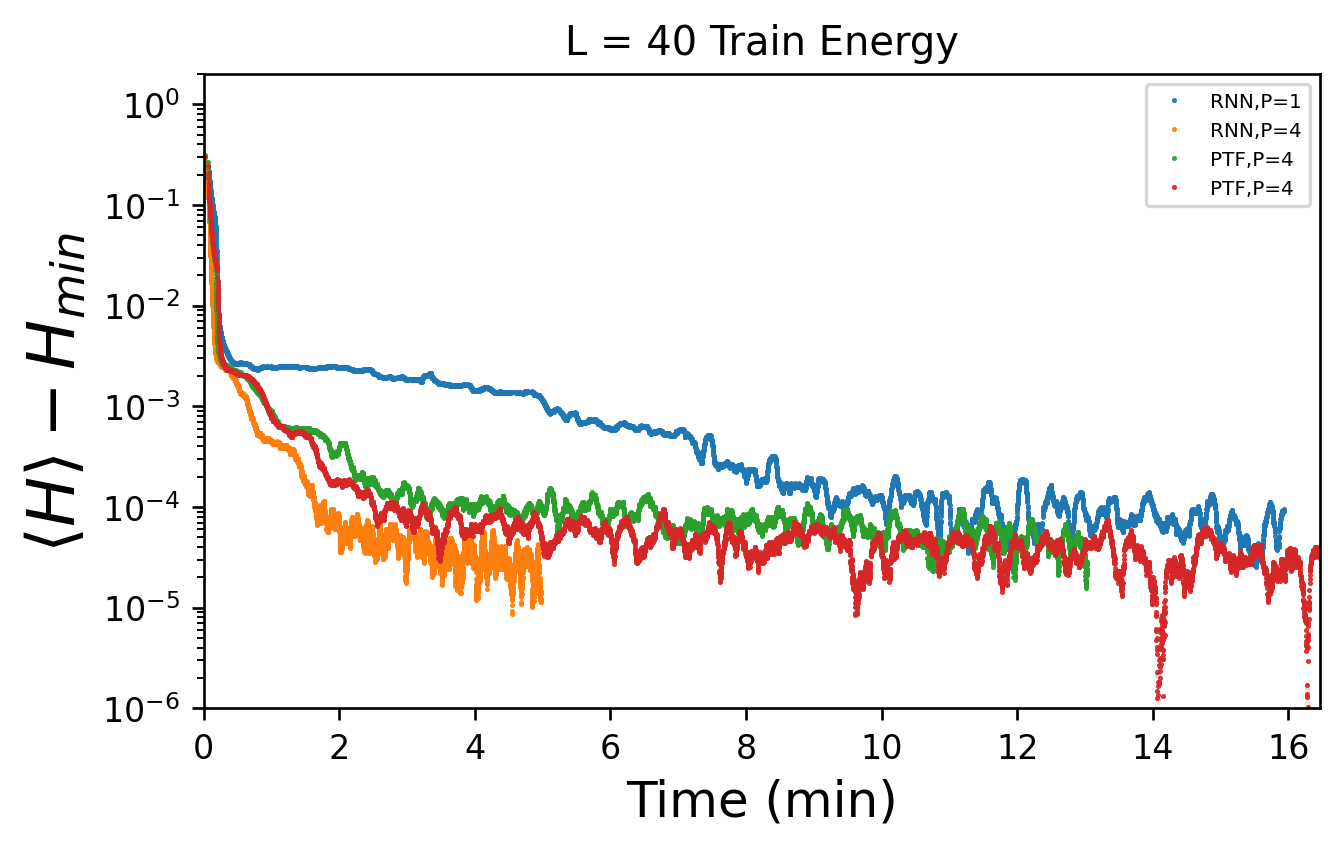

False -1.2732919061200112
L=100 RNN,P=1: -1.272859|L=100 RNN,P=4: -1.273247|L=100 PTF,h=: -1.273159|L=100 PTF,P=4: -1.273261|L=100 PTF,P=4: -1.273275|


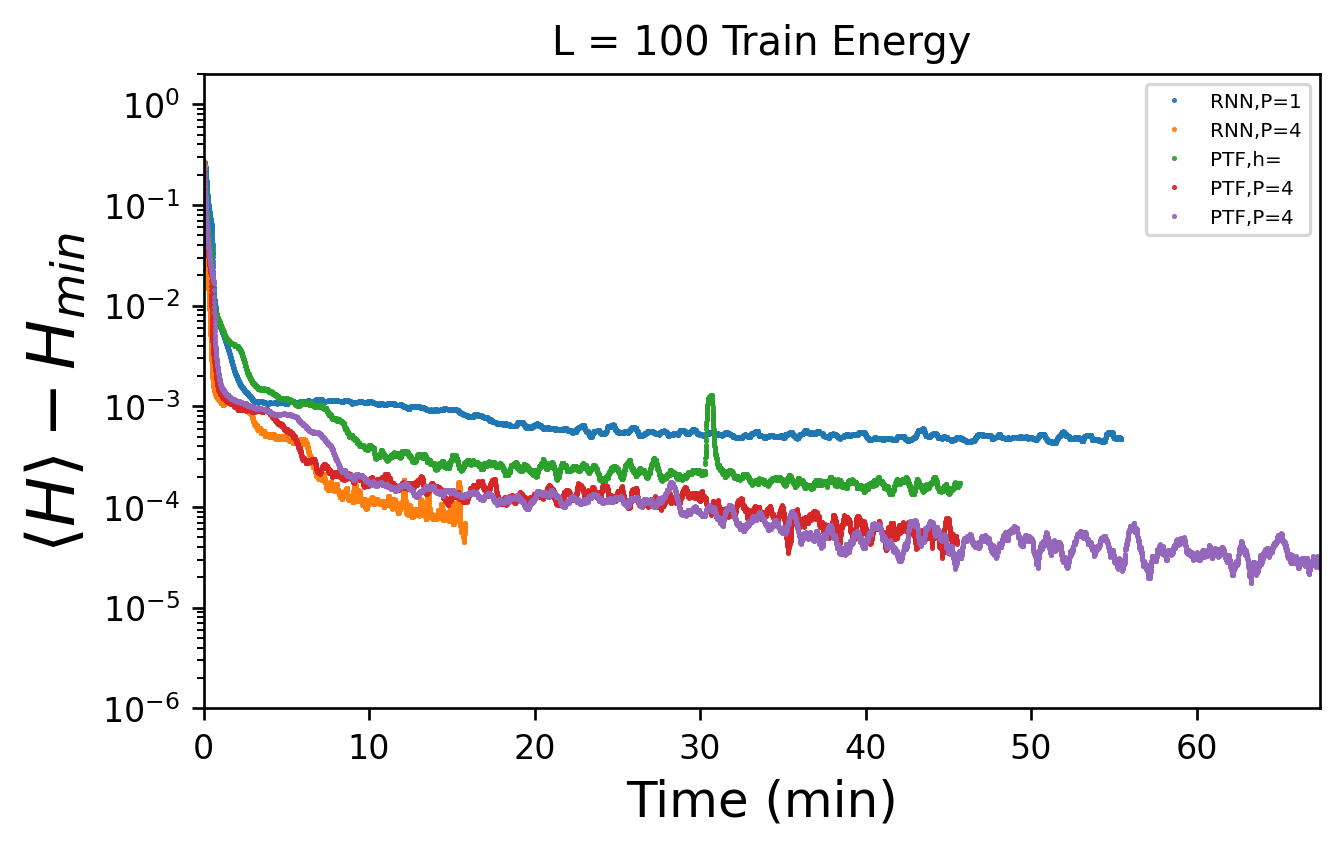

False -1.2732526347987563
L=200 RNN,P=4: -1.273038|L=200 PTF,P=4: -1.273214|


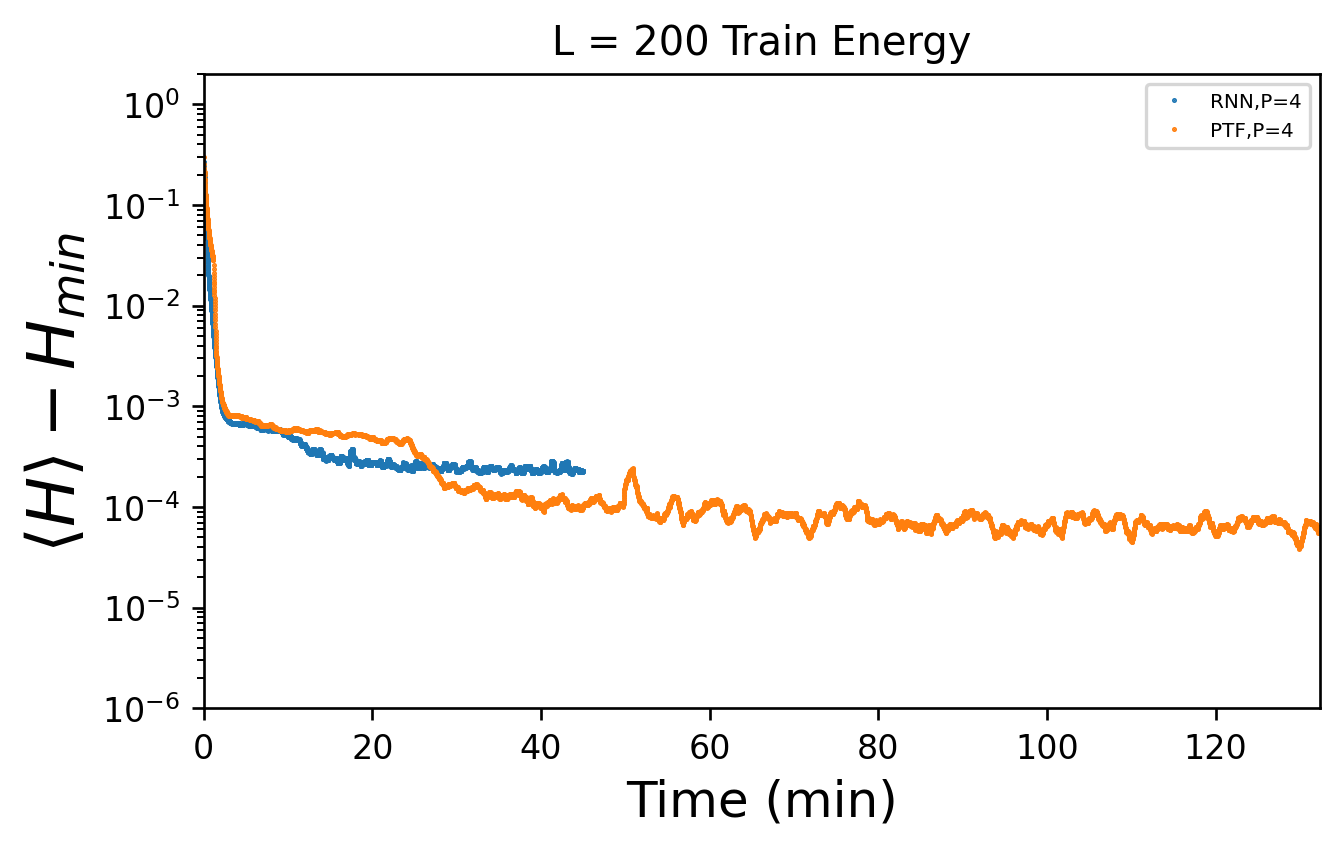

False -1.2732416391326764
L=500 RNN,P=4: -1.273116|L=500 PTF,P=4: -1.273211|


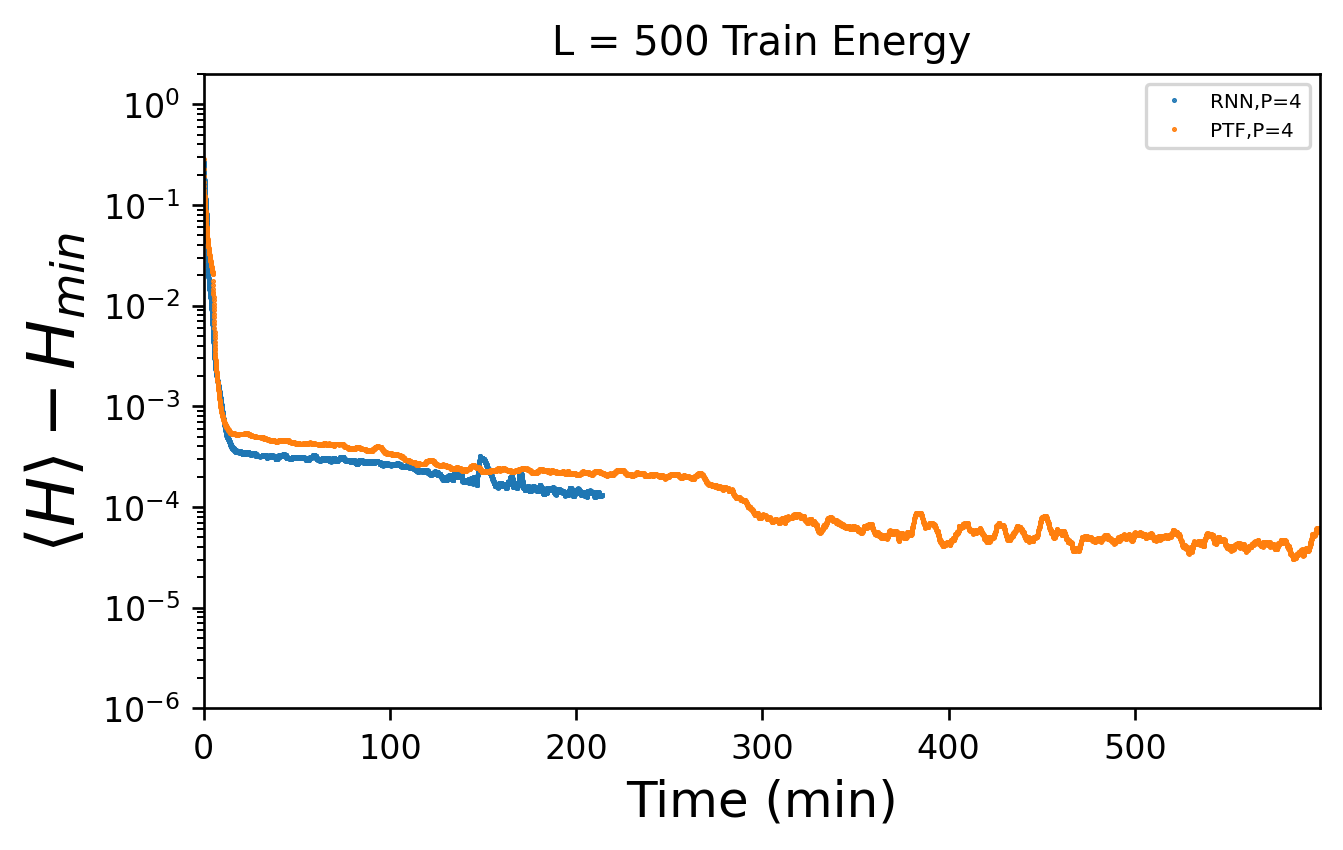

In [55]:
rnn=getpaths("RNN\\TFIM",["NoQ","B=512"],alldir=False)
ptf=getpaths("PTF\\TFIM",["NoQ"],alldir=False)
graphs(rnn+ptf,useTimes=True, metric="Train",label_idx=[0,-3],err=0,smoothing=100,show=True)


True -0.40522
L=64 TESTRNN: -0.405712|L=64 TESTRNN: -0.405669|


(1e-06, 1)

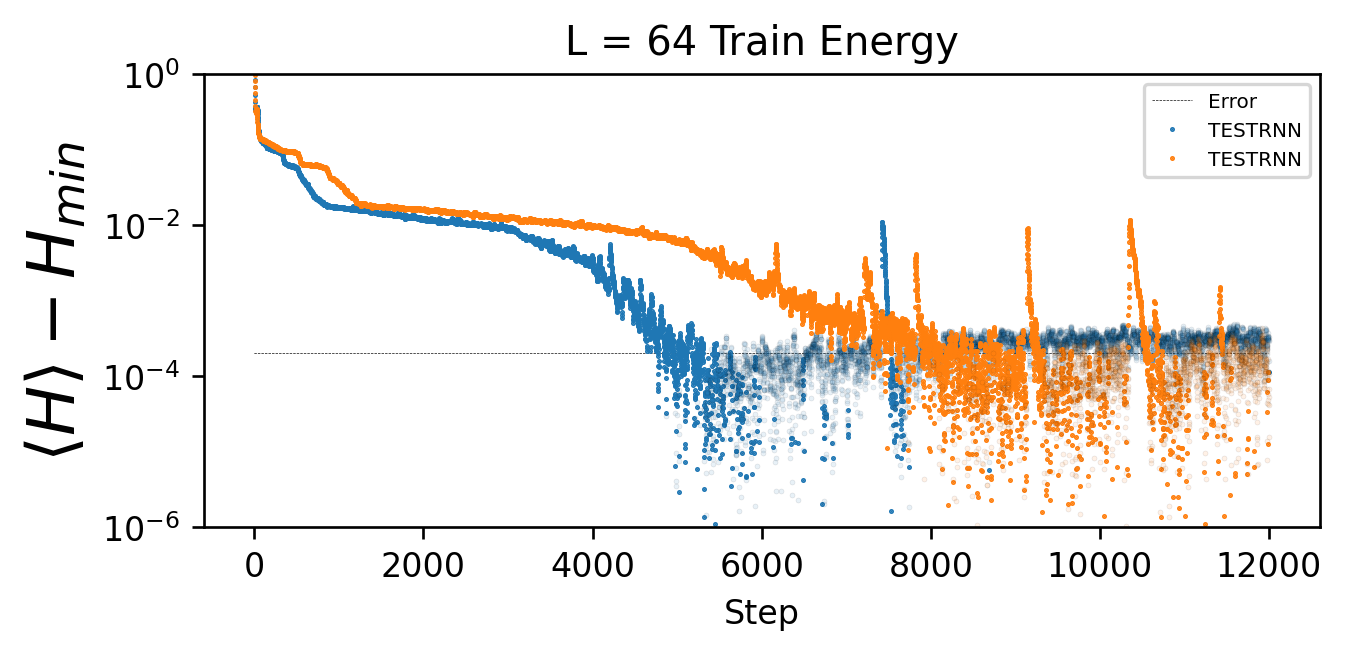

In [24]:
ptf=getpaths("TESTRNN\\Rydberg",["64-NoQ","Nh=256","0\\"],alldir=True)
graphs(ptf,useTimes=False, metric="Train",label_idx=[0],err=0,smoothing=10,show=False)
plt.ylim(1e-6,1)

In [47]:

os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

0

# The regular transformer run was stopped and then continued so I had to manually combine the results

True -0.38052
L=256 TF,kl=0.00\0: -0.377569|L=256 TF,kl=0.00\1: -0.380210|L=256 TF,kl=0.00\R: -0.380210|


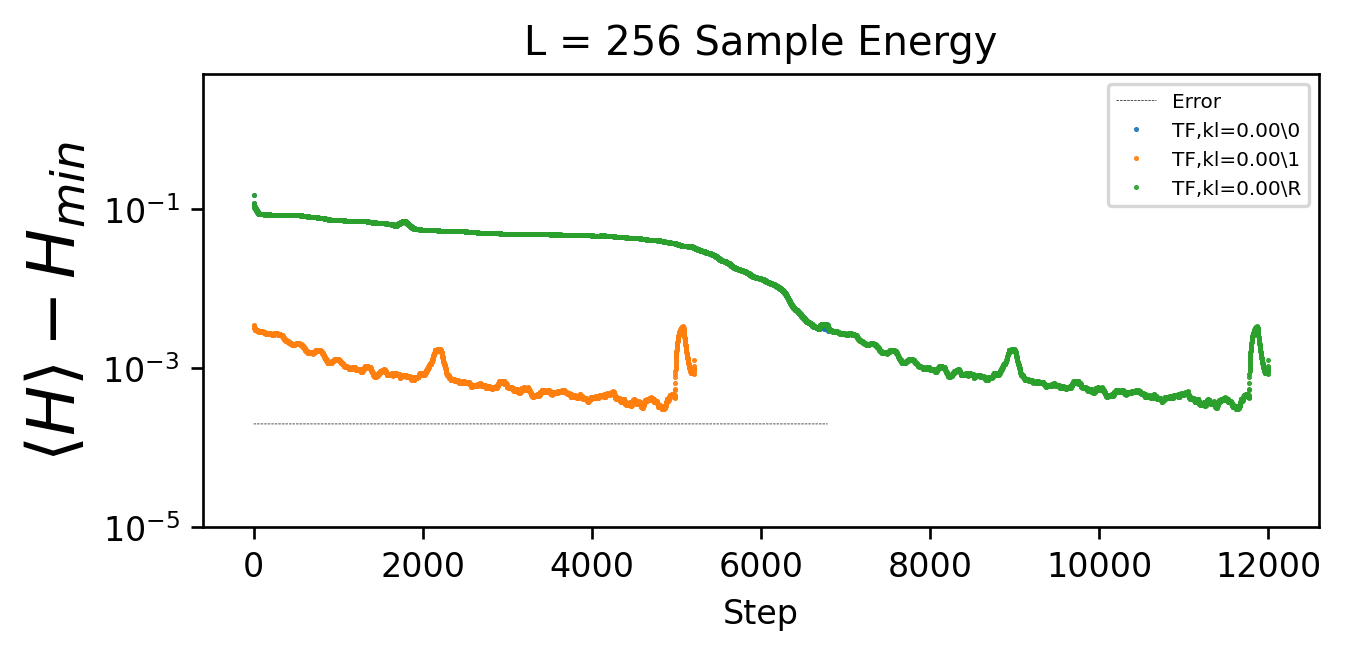

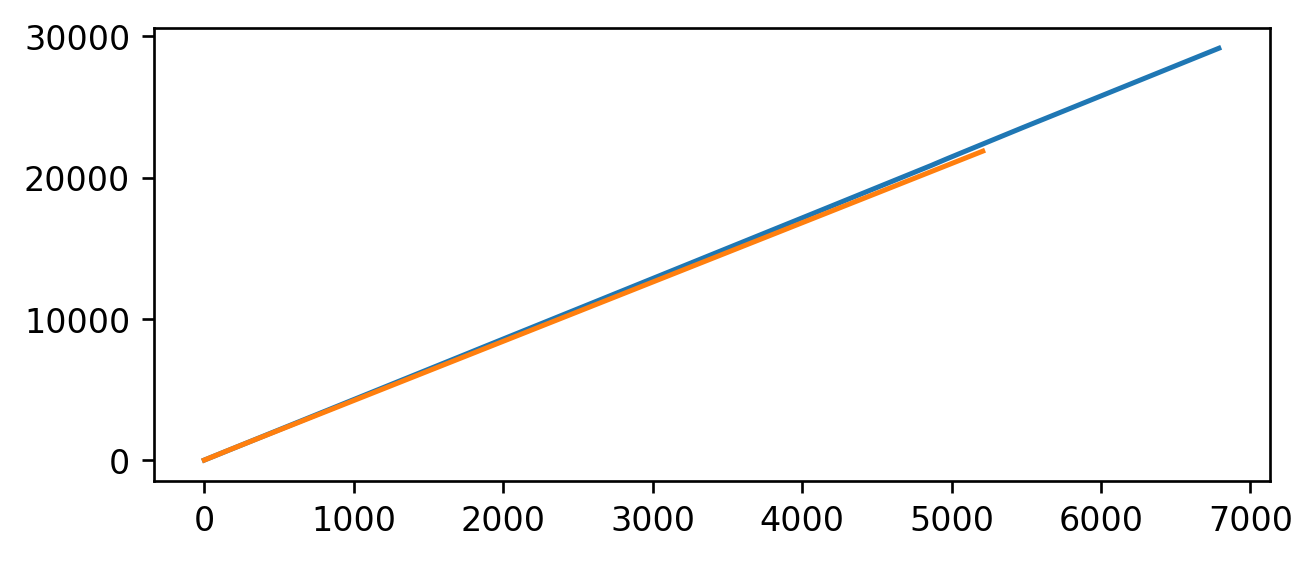

In [16]:
p=getpaths("TF\\Rydberg",["256","0.00\\"],alldir=True)
graphs(p,useTimes=False, metric="Sample",label_idx=[0,-1],err=False,smoothing=100)



fig = plt.figure(1,figsize=(6,2.5), dpi=240, facecolor='w', edgecolor='k')
debug0=np.load(p[256][0]+"\\DEBUG.npy")
debug1=np.load(p[256][1]+"\\DEBUG.npy")
plt.plot(debug0[:,-1])
plt.plot(debug1[:,-1])


#p = getpaths("PTFRNN\\Rydberg",["256","0.00\\"],alldir=True)
#debug2=np.load(p[256][0]+"\\DEBUG.npy")
#plt.plot(debug2[:,-1])


In [19]:
debug1[:,-1]+=debug0[-1,-1]

x = np.concatenate([debug0,debug1])

np.save("E:\\SharedContent\\NN-QSR\\TF\\Rydberg\\256-NoQ-B=256-K=256-Nh=128-kl=0.00\\R\\DEBUG.npy",x)

In [113]:
os.system("python ModelTester.py %s\\0 1024 64"%getpaths("PTFRNN\\Rydberg",["2304"])[2304][0])

0

In [216]:
p=getpaths("PTF\\Rydberg",["NoQ"])
for L in p:
    if L<256:
        for path in p[L]:
            print(path)
            os.system("python ModelTester.py %s\\0 1024"%path)

PTF\Rydberg\144-NoQ-B=256-K=256-Nh=128-kl=0.00
PTF\Rydberg\16-NoQ-B=256-K=256-Nh=128-kl=0.00
PTF\Rydberg\36-NoQ-B=256-K=256-Nh=128-kl=0.00
PTF\Rydberg\64-NoQ-B=128-K=128-Nh=128-kl=0.00
PTF\Rydberg\64-NoQ-B=16-K=16-Nh=128-kl=0.00
PTF\Rydberg\64-NoQ-B=256-K=256-Nh=128-kl=0.00
PTF\Rydberg\64-NoQ-B=32-K=32-Nh=128-kl=0.00


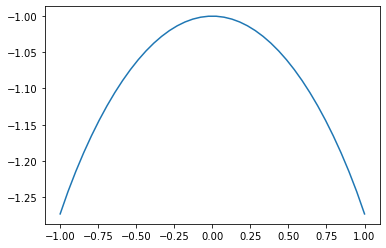

In [53]:
h=np.linspace(-1,1,40)
plt.plot(h,[energies.TFIM.ground(100,h0,1) for h0 in h])
plt.show()

In [47]:
[energies.TFIM.ground(100,h0,1) for h0 in h]

[-2.12708881994673]

In [110]:
sum(range(5,5+16))

200

In [112]:
20*8+12*8

256

In [111]:
5+8

13

In [114]:
import torch

x=torch.zeros(3,dtype=torch.bool)

In [115]:
x

tensor([False, False, False])

In [5]:
from RNN_QSR import PRNN

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)


In [6]:
PRNN.__name__

'PRNN'